# Facial Expression Recognition

### 1. Imports

In [17]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

### 2. Converting data sets - ***!!! Only if you want to resize the photos !!!***

In [8]:
img_size = 128

In [9]:
categories = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

In [10]:
def convert_data(source_path, save_path, categories):
    for category in categories:
        path_source = os.path.join(source_path, category)
        path_save = os.path.join(save_path, category)

        for img_name in os.listdir(path_source):
            try:
                img_array = cv2.imread(os.path.join(path_source, img_name))
                new_array = cv2.resize(img_array, (img_size, img_size))
                cv2.imwrite(os.path.join(path_save, img_name), new_array)
            except Exception as e:
                print("Error during data preparation")

**2.1 Training set**

In [4]:
train_data_directory_source = "./data/train"
train_data_directory_converted = "./data/train_resized"

In [21]:
convert_data(train_data_directory_source, train_data_directory_converted, categories)

**2.2 Test set**

In [5]:
test_data_directory_source = "./data/test"
test_data_directory_converted = "./data/test_resized"

In [23]:
convert_data(test_data_directory_source, test_data_directory_converted, categories)

### 3. Displaying Images

In [6]:
expression = "happy"

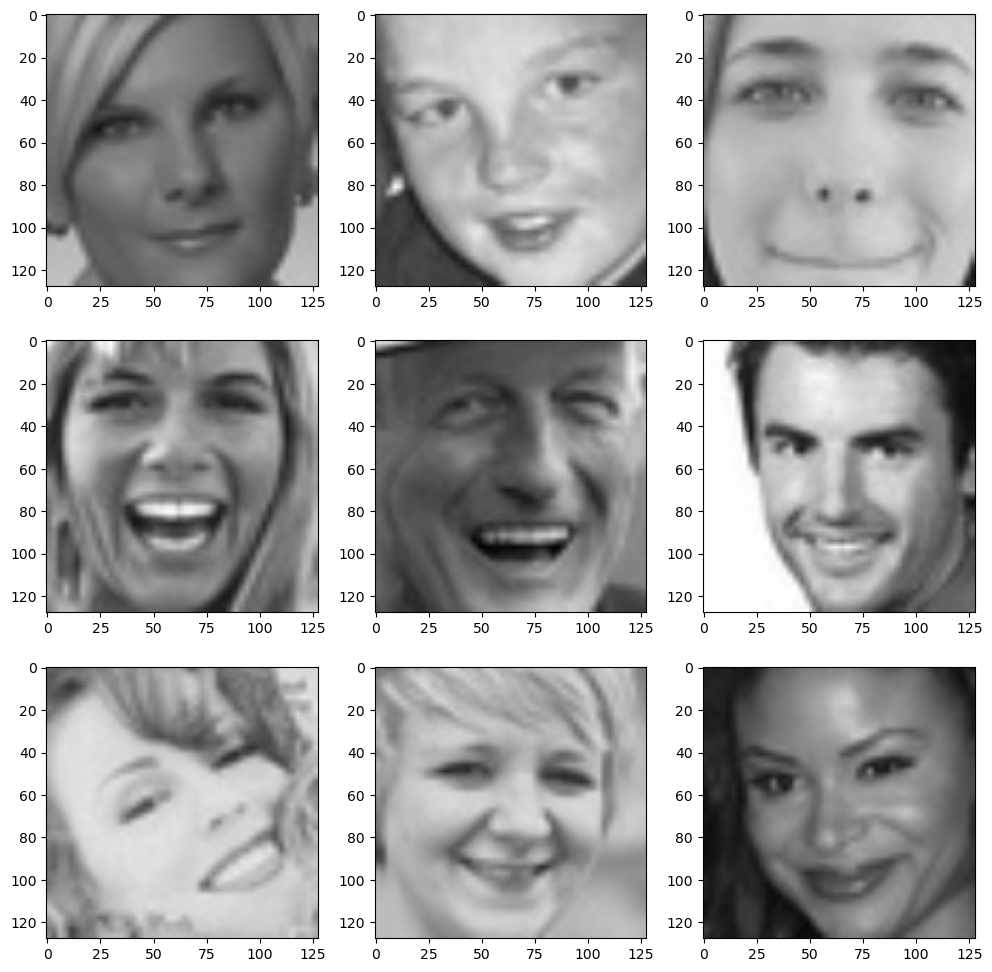

In [11]:
plt.figure(figsize= (12,12))

for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = tf.keras.utils.load_img(train_data_directory_converted + "/" + expression + "/"+
                                  os.listdir(train_data_directory_converted + "/" + expression)[i], target_size=(img_size, img_size))
    plt.imshow(img)
plt.show()

### 4. Data processing

In [26]:
batch_size  = 128

datagen_train  = ImageDataGenerator()
datagen_val = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(train_data_directory_converted,
                                              target_size = (img_size,img_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(test_data_directory_converted,
                                           target_size=(img_size,img_size),
                                           color_mode="grayscale",
                                           batch_size=batch_size,
                                           class_mode='categorical',
                                           shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### 5. Model creating

In [27]:
from keras.optimizers import Adam

n_classes = len(categories)

model = Sequential()


model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (img_size,img_size,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))


model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))


model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(n_classes, activation='softmax'))

In [28]:
model.compile(optimizer=Adam(lr = 0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      640       
                                                                 
 batch_normalization_6 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 128)      

C:\Users\adamd\anaconda3\envs\tf_2.10\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### 6. Model training

In [29]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(filepath="./model_final_extended.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=3,
                               verbose=1,
                               restore_best_weights=True
                               )

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.2,
                                        patience=3,
                                        verbose=1,
                                        min_delta=0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learning_rate]

In [30]:
model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

In [31]:
epochs = 48

In [32]:
history = model.fit_generator(generator=train_set,
                              steps_per_epoch=train_set.n//train_set.batch_size,
                              epochs=epochs,
                              validation_data = test_set,
                              validation_steps = test_set.n//test_set.batch_size,
                              callbacks=callbacks_list
                              )

C:\Users\adamd\AppData\Local\Temp\ipykernel_15280\1412514093.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/48
224/224 [==============================] - ETA: 0s - loss: 1.7536 - accuracy: 0.3307
Epoch 1: val_accuracy improved from -inf to 0.27065, saving model to .\model_final_extended.h5
224/224 [==============================] - 152s 651ms/step - loss: 1.7536 - accuracy: 0.3307 - val_loss: 1.8509 - val_accuracy: 0.2706 - lr: 0.0010
Epoch 2/48
224/224 [==============================] - ETA: 0s - loss: 1.4082 - accuracy: 0.4605
Epoch 2: val_accuracy improved from 0.27065 to 0.31836, saving model to .\model_final_extended.h5
224/224 [==============================] - 101s 449ms/step - loss: 1.4082 - accuracy: 0.4605 - val_loss: 1.9649 - val_accuracy: 0.3184 - lr: 0.0010
Epoch 3/48
224/224 [==============================] - ETA: 0s - loss: 1.2314 - accuracy: 0.5312
Epoch 3: val_accuracy improved from 0.31836 to 0.37486, saving model to .\model_final_extended.h5
224/224 [==============================] - 102s 455ms/step - loss: 1.2314 - accuracy: 0.5312 - val_loss: 1.7540 - val_accurac

### 6,5 Model 2

In [161]:
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.3,
)

validation_data_gen = ImageDataGenerator(rescale=1./255)

# Preprocess all test images
train_generator = train_data_gen.flow_from_directory(
    "./data/train",
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode='categorical',
    shuffle=True)

# Preprocess all train images
validation_generator = validation_data_gen.flow_from_directory(
    "./data/test",
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode='categorical',
    shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [162]:
# create model structure
emotion_model = Sequential([
    #block-1
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    #block-2
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    #block-3
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    #block-4
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    #block-5
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

emotion_model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001,epsilon=1e-06),
    loss="categorical_crossentropy",
    metrics=['accuracy'])

emotion_model.summary()
# Train the neural network/model
emotion_model_info = emotion_model.fit(
    train_generator,
    steps_per_epoch=28709 // 64,
    epochs=60,
    validation_data=validation_generator,
    validation_steps=7178 // 64)


emotion_model.save('facial_emotions_model.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 18, 18, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 64)         0         
 2D)                                                    

### 7. Results

**7.1 Loss**

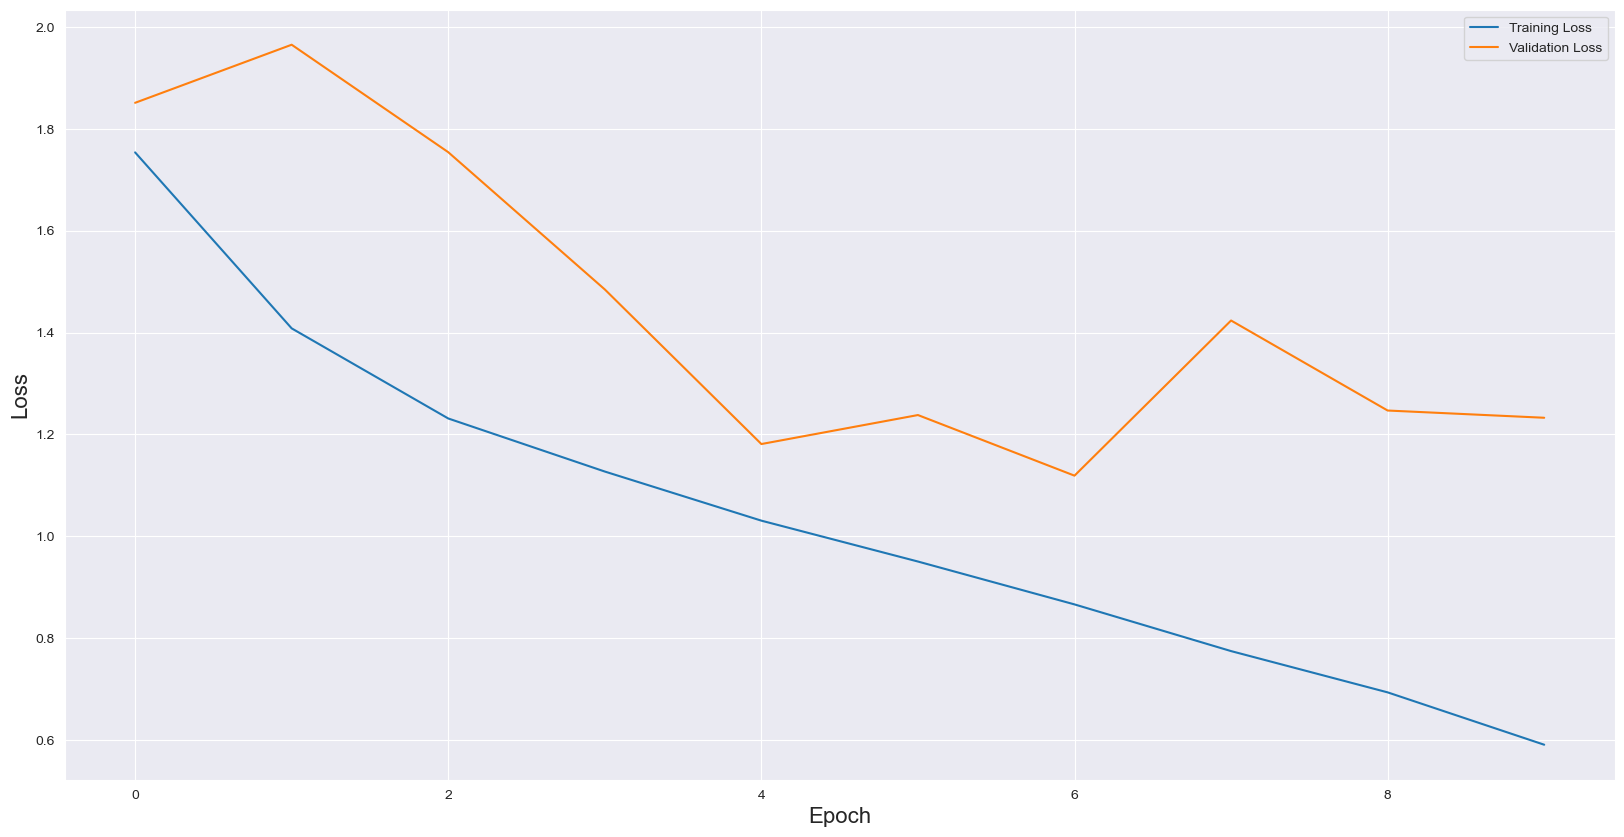

In [36]:
plt.figure(figsize=(20,10))
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

**7.2 Accuracy**

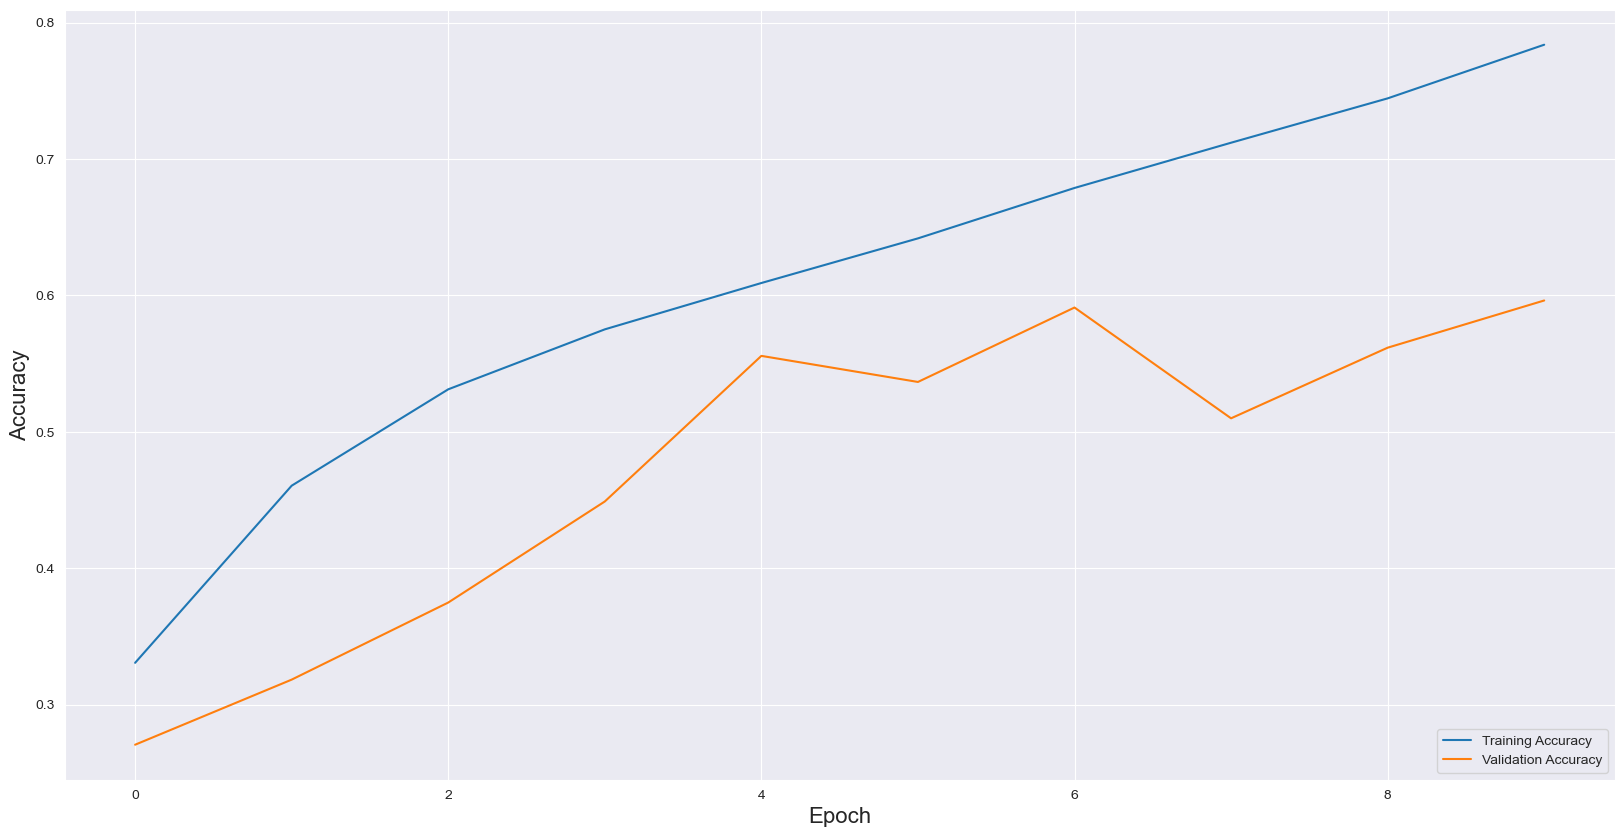

In [37]:
plt.figure(figsize=(20,10))
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

**7.3 Loss - structure 2**

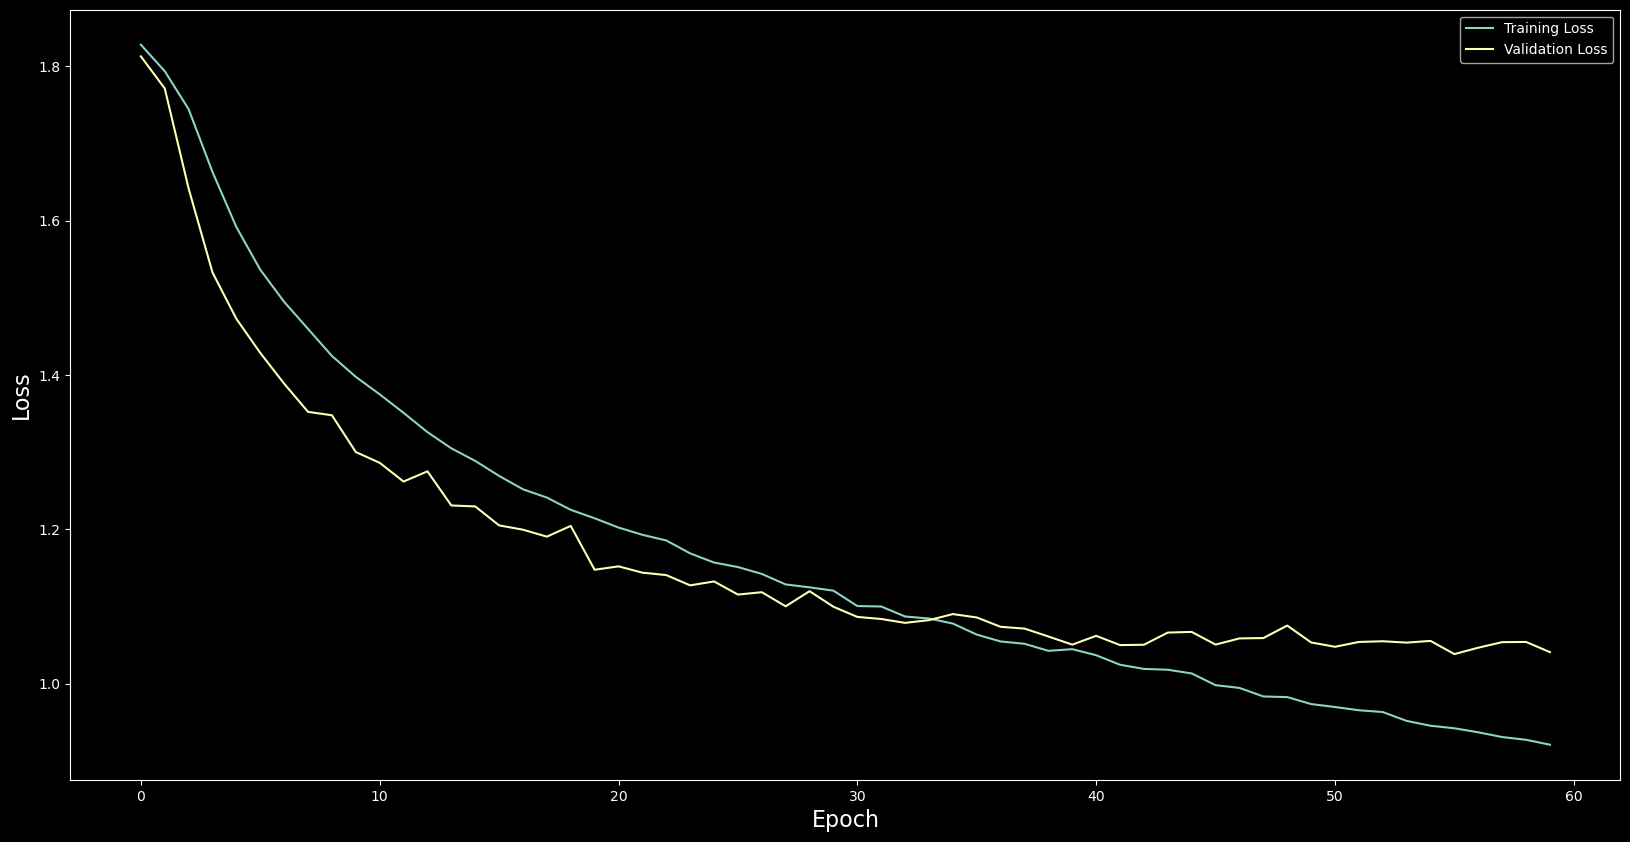

In [163]:
plt.figure(figsize=(20,10))
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(emotion_model_info.history['loss'], label='Training Loss')
plt.plot(emotion_model_info.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

**7.4 Accuracy - structure 2**

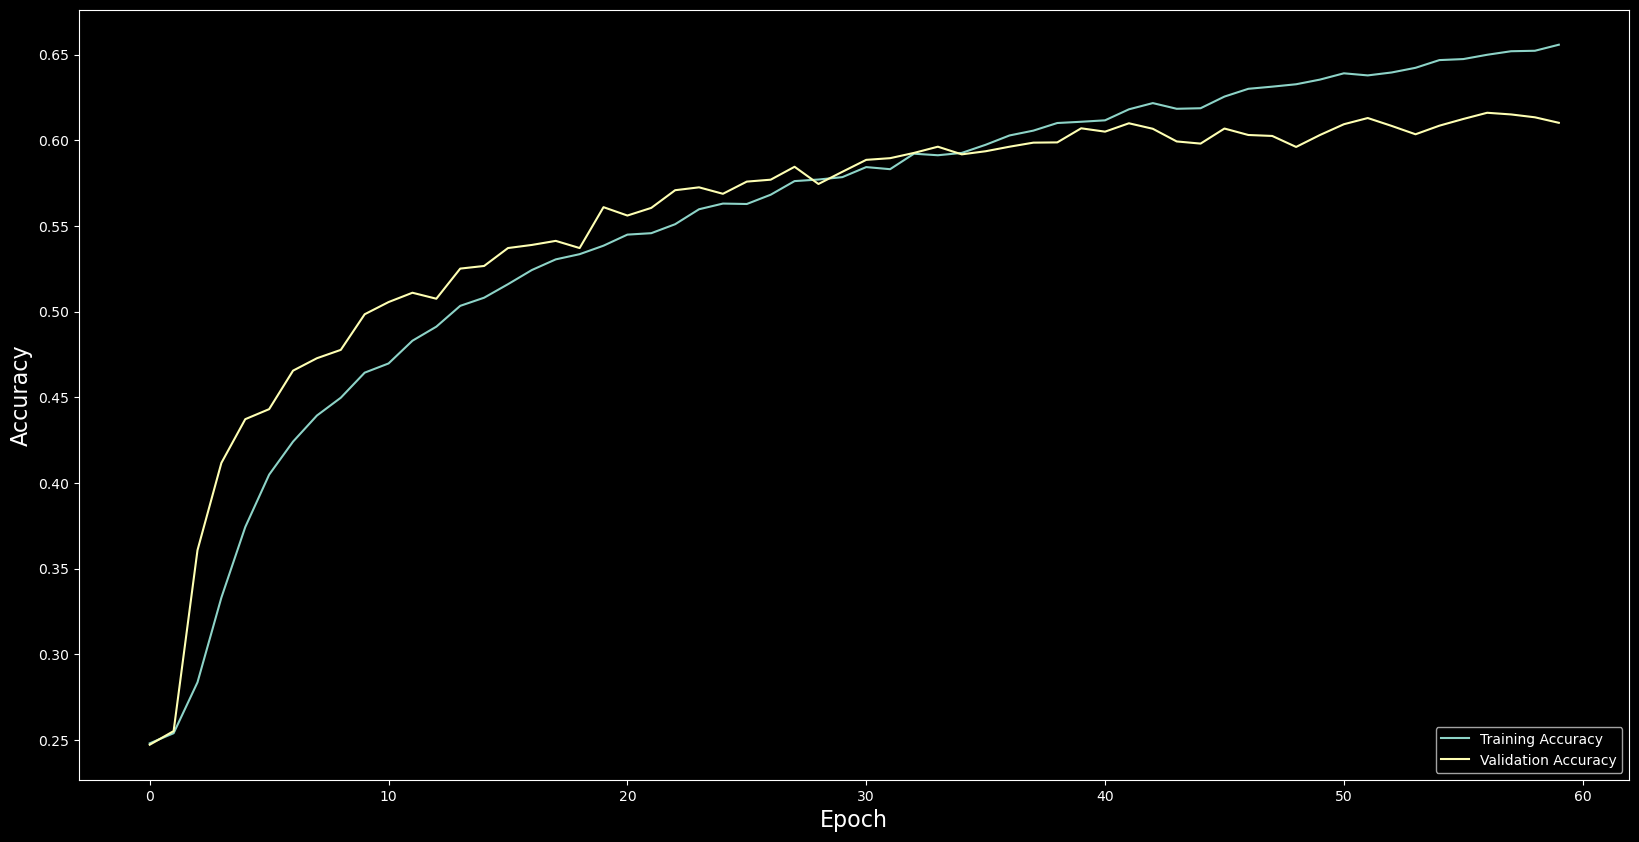

In [164]:
plt.figure(figsize=(20,10))
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(emotion_model_info.history['accuracy'], label='Training Accuracy')
plt.plot(emotion_model_info.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

**7.5 Sample visualization**

In [173]:
# model_name = 'model.h5'
# input_img_size = 48 # - słaby

# model_name = 'model2.h5'
# input_img_size = 48

# model_name = 'model_e150_bs32.h5'
# input_img_size = 48  # - tragedia

# model_name = 'model_final.h5'
# input_img_size = 48

# model_name = 'model_final_extended.h5'
# input_img_size = 128

model_name = 'facial_emotions_model.h5'
input_img_size = 48

In [174]:
from keras.models import load_model

classifier = load_model(model_name)

In [175]:
categories = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

1/1 [==============================] - 0s 18ms/step


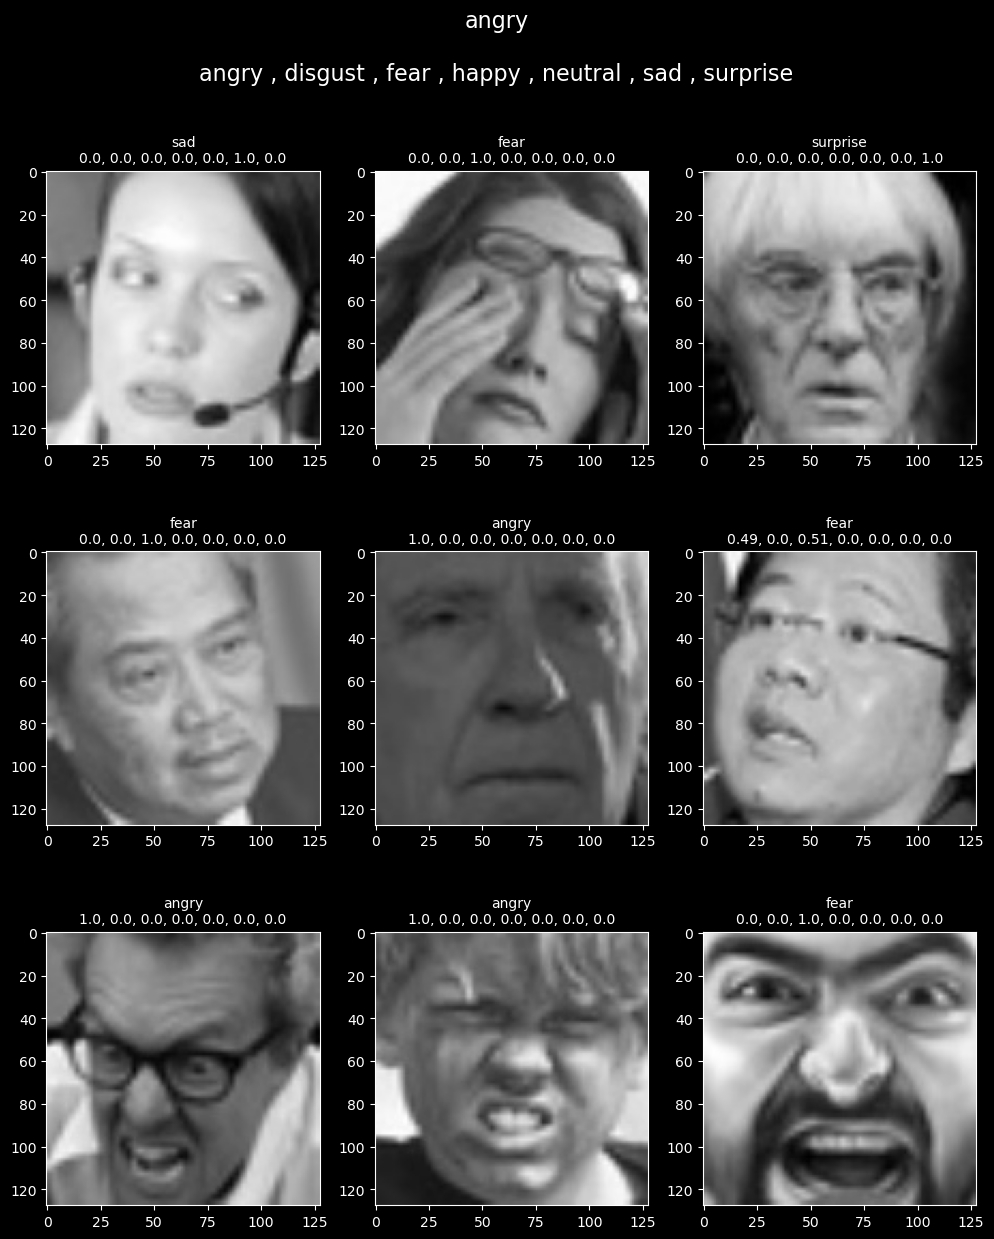

1/1 [==============================] - 0s 18ms/step


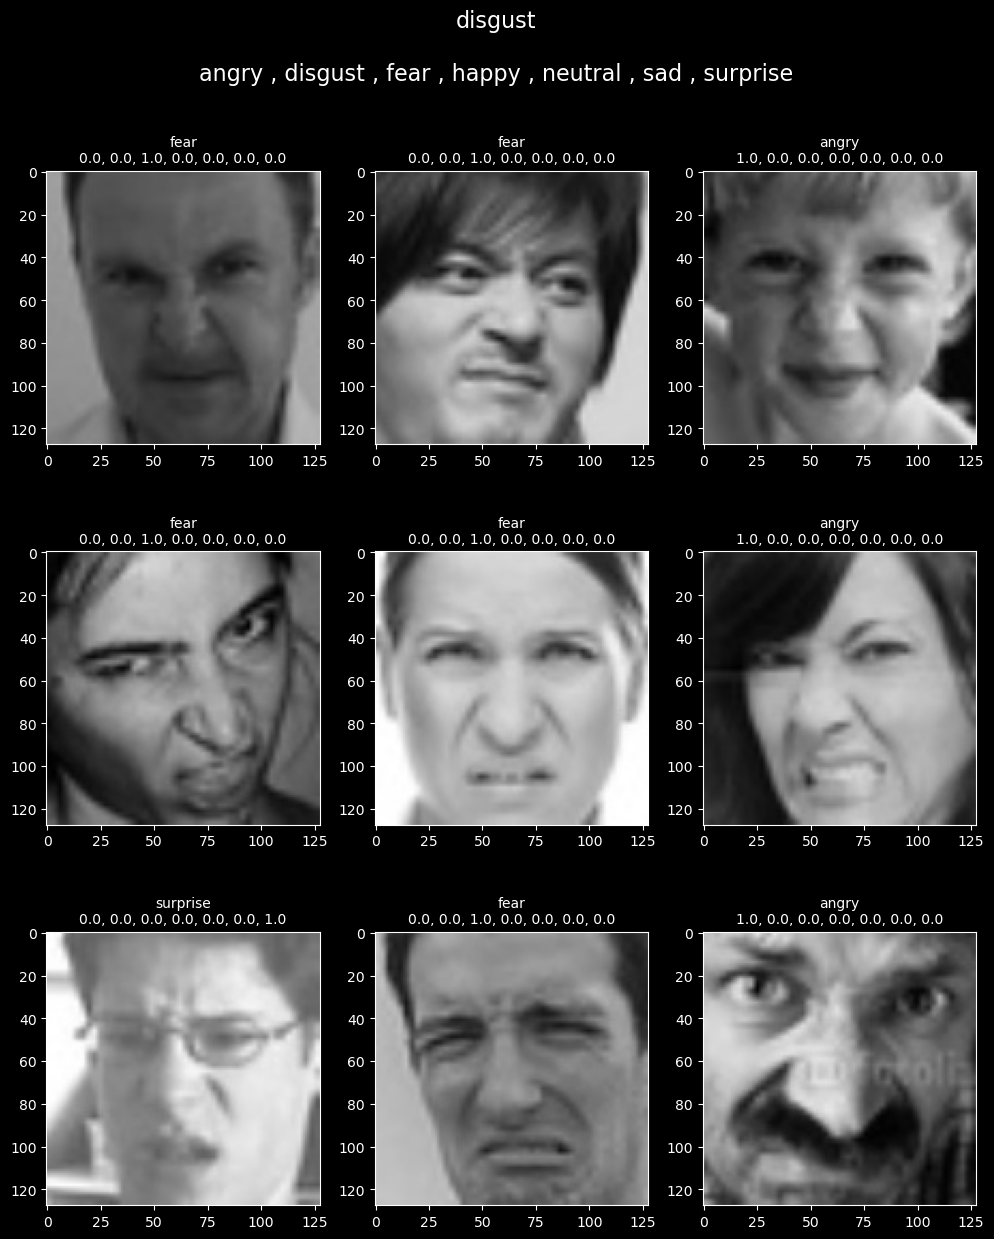

1/1 [==============================] - 0s 19ms/step


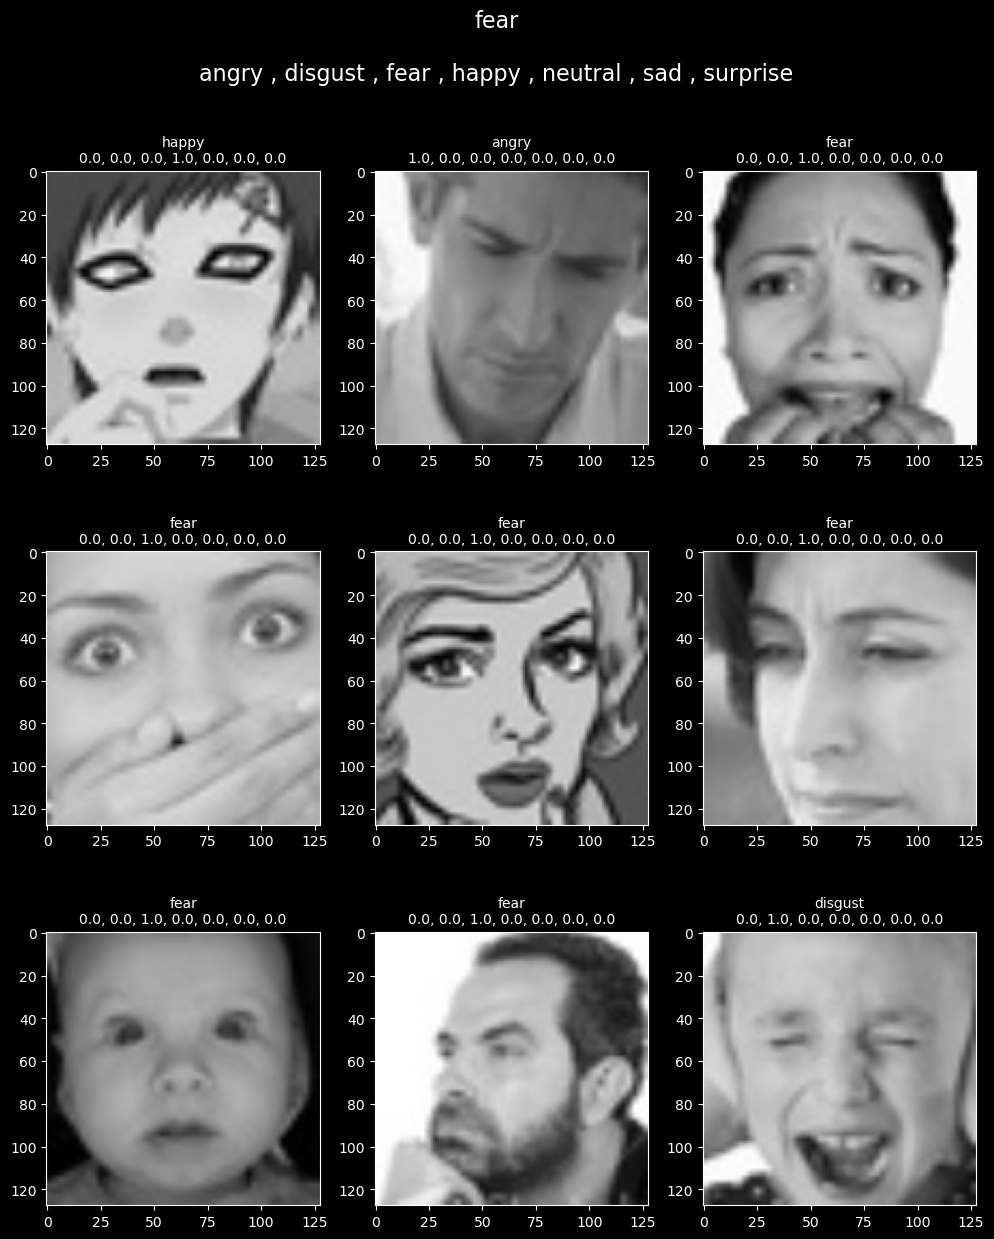

1/1 [==============================] - 0s 19ms/step


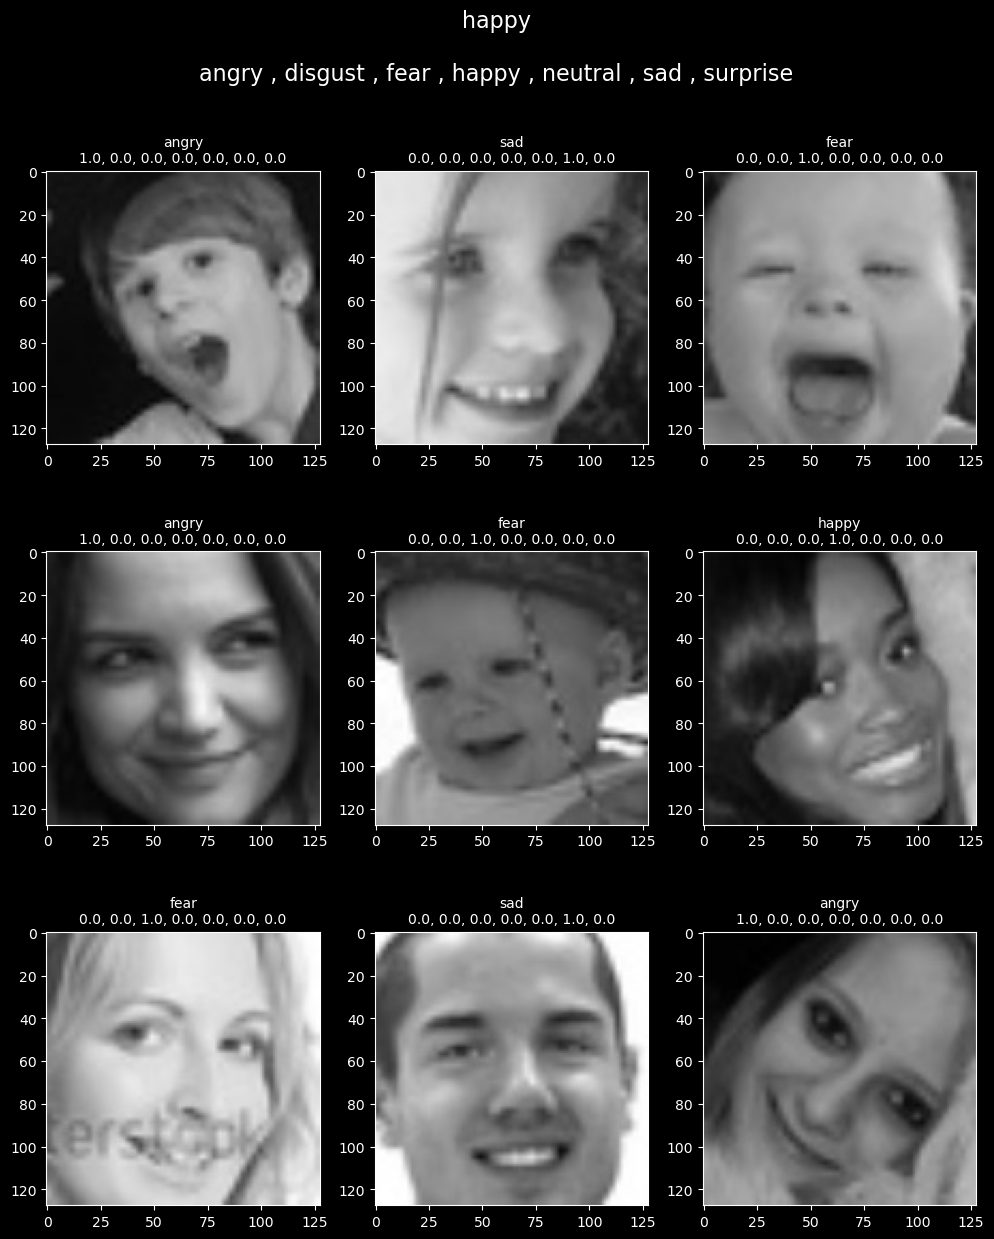

1/1 [==============================] - 0s 20ms/step


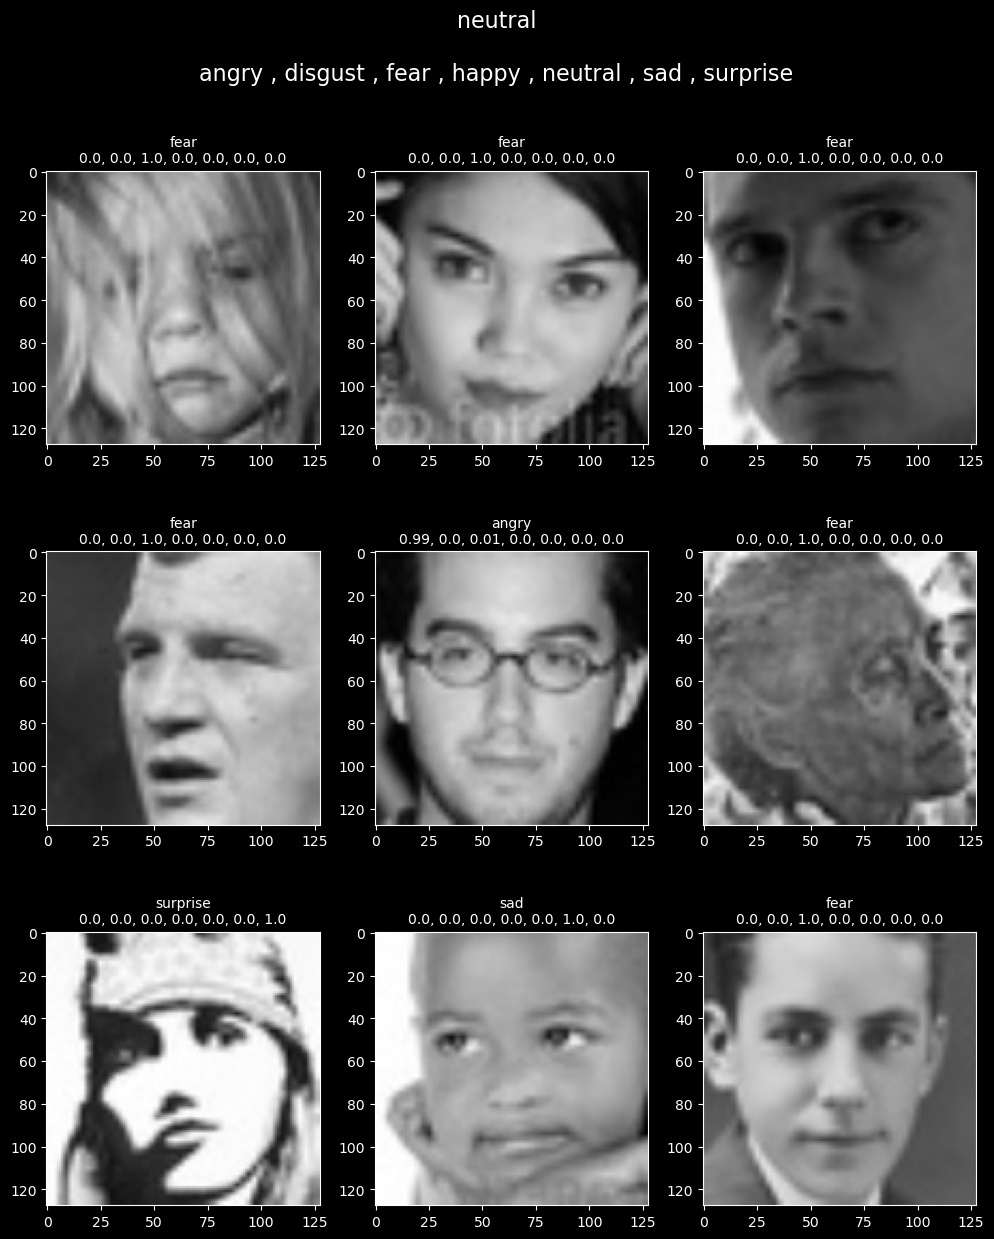

1/1 [==============================] - 0s 17ms/step


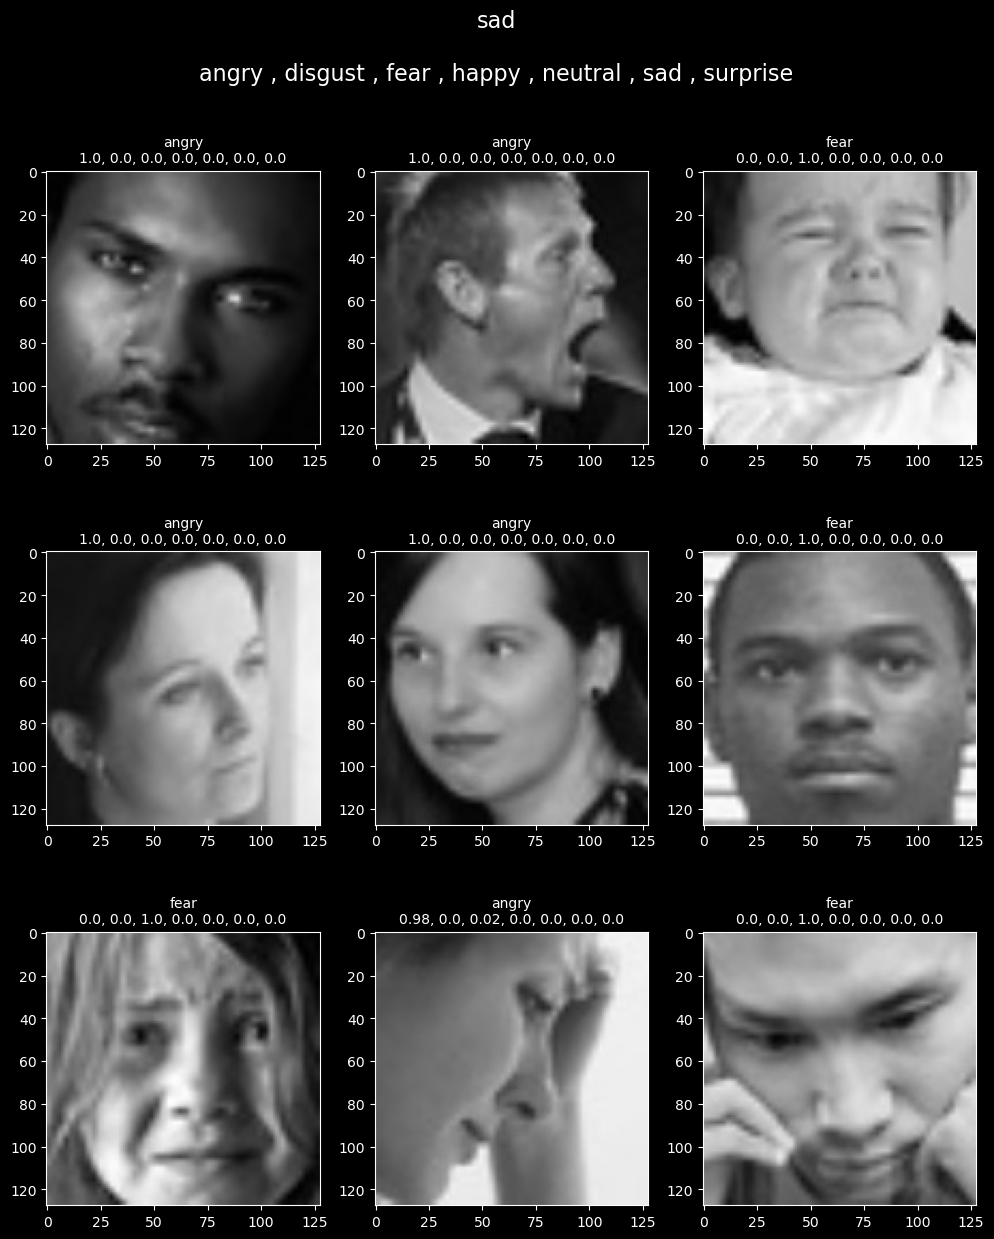

1/1 [==============================] - 0s 19ms/step


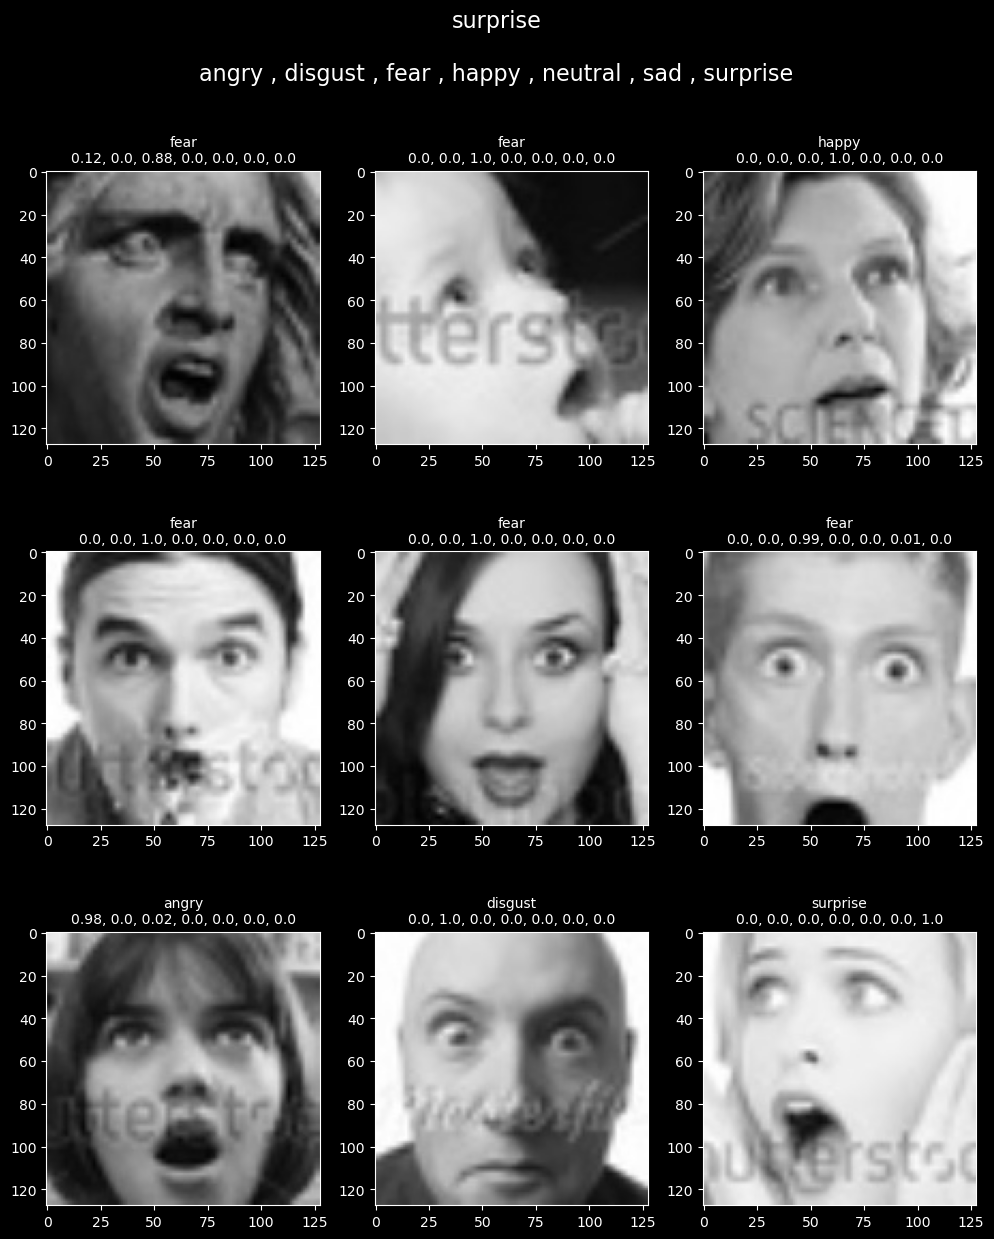

In [176]:
for category in categories:
    fig = plt.figure(figsize=(12, 14))

    for i in range(1, 10, 1):
        plt.subplot(3, 3, i)
        path = test_data_directory_converted + "/" + category + "/" + os.listdir(test_data_directory_converted + "/" + category)[i]

        img_array = cv2.imread(path)
        new_array = cv2.resize(img_array, (input_img_size, input_img_size))
        new_array.shape
        new_array = np.expand_dims(new_array, axis=0)
        new_array = np.reshape(new_array, (-1, input_img_size, input_img_size, 1))
        prediction = classifier.predict(new_array)[0]
        label = categories[prediction.argmax()]

        prediction_str_list = [str(round(number, 2)) for number in prediction]
        prediction_str = ', '.join(prediction_str_list)

        plt.imshow(img_array)
        plt.title(label + '\n' + prediction_str, fontsize=10)
        plt.style.use('dark_background')

    fig.suptitle(f'{category}' + '\n\n' + ' , '.join(categories), fontsize=16)
    plt.show()